In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os,sys
import pylab as plt
%matplotlib inline

import glob


In [2]:
src_dir = '../src'
sys.path.append(src_dir)
from jsd import jsdalpha

In [3]:
src_meta = '../../gutenberg/src/'
sys.path.append(src_meta)
from metaquery import meta_query


In [4]:
# Load meta data

In [5]:
meta=meta_query(path=src_meta+'../metadata/metadata.csv')

# Subjects

In [6]:
Smax = 20

meta.reset()
meta.filter_lang('en')
subjects=meta.get_subjects_counts()


list_subjects = []
for s,n_s in subjects.most_common(Smax):
    print(s,n_s)
    list_subjects+=[s]

Short stories 1605
Science fiction 1508
Fiction 1290
Adventure stories 793
Conduct of life -- Juvenile fiction 645
Love stories 623
Detective and mystery stories 568
English wit and humor -- Periodicals 556
Historical fiction 502
Poetry 450
Western stories 430
Man-woman relationships -- Fiction 428
England -- Fiction 356
Friendship -- Juvenile fiction 325
Domestic fiction 296
Young women -- Fiction 295
Humorous stories 279
Adventure and adventurers -- Juvenile fiction 258
English fiction -- 19th century 250
Sea stories 249


In [7]:
print(list_subjects)

['Short stories', 'Science fiction', 'Fiction', 'Adventure stories', 'Conduct of life -- Juvenile fiction', 'Love stories', 'Detective and mystery stories', 'English wit and humor -- Periodicals', 'Historical fiction', 'Poetry', 'Western stories', 'Man-woman relationships -- Fiction', 'England -- Fiction', 'Friendship -- Juvenile fiction', 'Domestic fiction', 'Young women -- Fiction', 'Humorous stories', 'Adventure and adventurers -- Juvenile fiction', 'English fiction -- 19th century', 'Sea stories']


In [8]:
list_subjects += ['All']
list_books = []

lang = 'en'
for s in list_subjects:
    meta.reset()
    meta.filter_lang(lang,how='only')
    if s=='All':
        pass
    else:
        meta.filter_subject(s,how='any')
    books_tmp = meta.get_ids()
    list_books += [books_tmp]

In [9]:
[len(h) for h in list_books]

[1636,
 1508,
 1292,
 794,
 670,
 628,
 568,
 556,
 513,
 451,
 430,
 429,
 356,
 329,
 296,
 296,
 281,
 261,
 250,
 249,
 46330]

In [10]:
# arr_alpha = np.array([0.0,1.0,2.0])
arr_alpha = np.linspace(0.0,2.0,21)

Npair = 1000
weights = False ## standard 1/2,1.2
normalized = True ## 0<=divergence <=1

path_read = '../../gutenberg/data/counts/'

list_jsdalpha_in = []
list_jsdalpha_out = []

list_labels = []
for i_s,s in enumerate(list_subjects[:-1]):
    print(s)
    list_jsd_in_tmp = []
    list_jsd_out_tmp = []
    books_tmp=list_books[i_s]
    books_all = list_books[-1]
    for i_Npair in range(Npair):
        ## 1st book from the subject
        book_sel = True
        while book_sel== True:
            pg1, = np.random.choice(books_tmp,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg1)
            filename1 = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename1):
                book_sel = False
        ## 2nd book: from the subject - IN
        book_sel = True
        while book_sel== True:
            pg2_in, = np.random.choice(books_tmp,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg2_in)
            filename2_in = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename2_in) and pg1!=pg2_in:
                book_sel = False 
        ## 2nd book: NOT from the subject - OUT
        book_sel = True
        while book_sel== True:
            pg2_out, = np.random.choice(books_all,replace=False,size=1)
            fname_read = '%s_counts.txt'%(pg2_out)
            filename2_out = os.path.join(path_read,fname_read)            
            if os.path.isfile(filename2_out) and pg1!=pg2_out:
                book_sel = False        

        jsd_in = jsdalpha(filename1,filename2_in,alpha=arr_alpha,weights=weights,normalized=normalized)
        jsd_out = jsdalpha(filename1,filename2_out,alpha=arr_alpha,weights=weights,normalized=normalized)

        list_jsd_in_tmp += [jsd_in]
        list_jsd_out_tmp += [jsd_out]

    list_jsdalpha_in += [list_jsd_in_tmp]
    list_jsdalpha_out += [list_jsd_out_tmp]

Short stories
Science fiction
Fiction
Adventure stories
Conduct of life -- Juvenile fiction
Love stories
Detective and mystery stories
English wit and humor -- Periodicals
Historical fiction
Poetry
Western stories
Man-woman relationships -- Fiction
England -- Fiction
Friendship -- Juvenile fiction
Domestic fiction
Young women -- Fiction
Humorous stories
Adventure and adventurers -- Juvenile fiction
English fiction -- 19th century
Sea stories


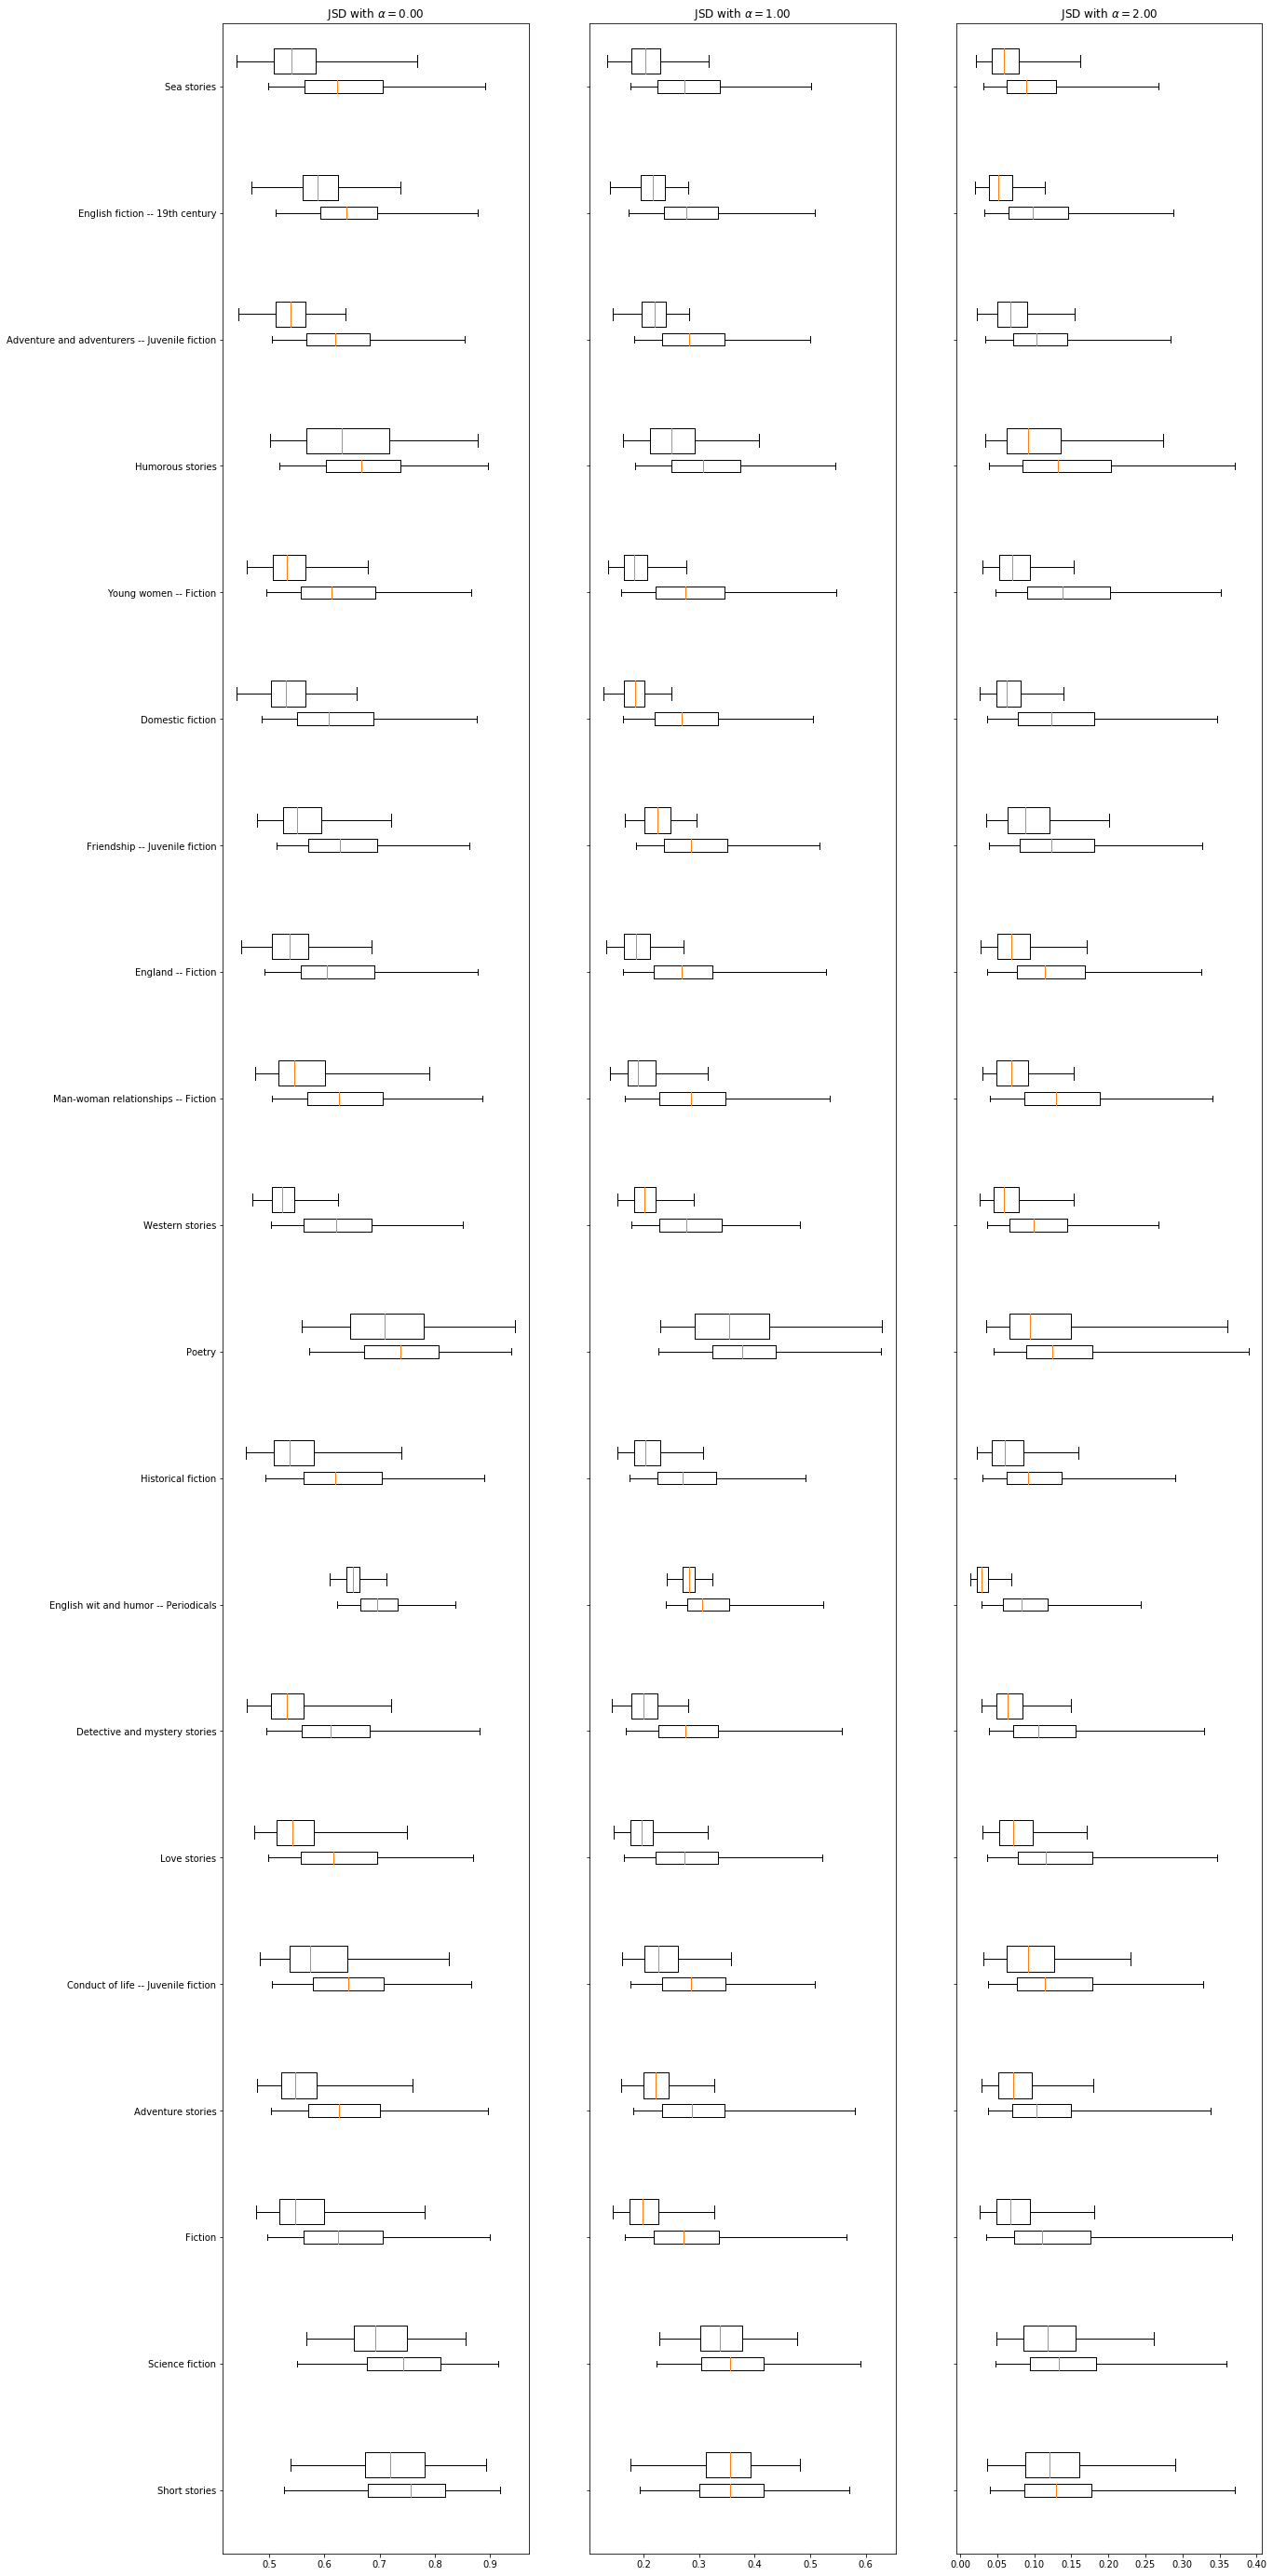

In [28]:
alpha_plot = [0.0,1.0,2.0]
f=plt.figure(figsize = (20,50))
i_plot = 0
for i_alpha,alpha in enumerate(arr_alpha):
    if alpha in alpha_plot:
        ax=f.add_subplot(1,3,i_plot+1)
        list_jsd_in_plot = [ [h[i_alpha] for h in jsd_tmp] for jsd_tmp in list_jsdalpha_in ]
        list_jsd_out_plot = [ [h[i_alpha] for h in jsd_tmp] for jsd_tmp in list_jsdalpha_out ]
        x = np.arange(Smax)
        h=-0.2
        ## within distances: large box
        _ =ax.boxplot(list_jsd_in_plot,positions=x,
                      vert=False,whis=[2.5,97.5],labels=list_subjects[:-1],sym='',widths=0.2)
        ## across distances: small box
        _ =ax.boxplot(list_jsd_out_plot,positions=x+h,
                      vert=False,whis=[2.5,97.5],labels=list_subjects[:-1],sym='',widths=0.1)

        _ = ax.set_title(r'JSD with $\alpha = %.2f$'%(alpha))

        if i_plot>0:
            ax.set_yticklabels([])
        i_plot+=1


## vary the threshold and then calculate the number of correct classifications
## ROC as a function of alpha

In [15]:
list_acc_mu = []
list_acc_std = []

for i_alpha,alpha in enumerate(arr_alpha):
    list_acc_tmp = []

    for i_S,s in enumerate(list_subjects[:-1]):
        n_acc = 0
        jsd_tmp_in = [h[i_alpha] for h in list_jsdalpha_in[i_S]]
        jsd_tmp_out = [h[i_alpha] for h in list_jsdalpha_out[i_S]]
        for i in range(Npair):
            din = jsd_tmp_in[i]
            dout=jsd_tmp_out[i]
            if din<dout:
                n_acc+=1
        list_acc_tmp += [n_acc/Npair]
#         print(n_acc/Npair)
#     print(np.mean(list_acc_tmp))
#     print(np.std(list_acc_tmp))
    list_acc_mu+=[np.mean(list_acc_tmp)]    
    list_acc_std+=[np.std(list_acc_tmp)]



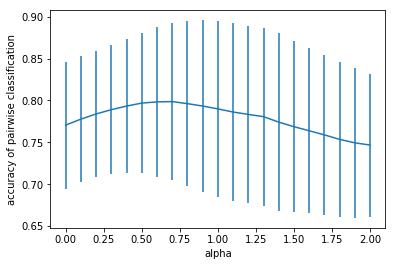

In [23]:
x=arr_alpha
y=list_acc_mu
yerr=np.array(list_acc_std)#/np.sqrt(Smax)

# yerr=np.array(list_acc_std)/np.sqrt(Smax)
_=plt.errorbar(x,y,yerr=yerr)
plt.xlabel('alpha')
plt.ylabel('accuracy of pairwise classification')